# 05c parameter optimisation 

In [1]:
#|default_exp core.05c_parameter_optimisation

In [2]:
#|export
import autograd.numpy as np
from autograd import grad, jacobian, hessian
from scipy.optimize import minimize
import scipy.stats as stat
import pandas as pd
from matplotlib import pyplot as plt

from dementia_inequalities import const, log, utils, tools 

---

In [3]:
#|export 
df_dem_plus = pd.read_csv(const.output_path+'/df_dem_plus.csv')

In [4]:
df_dem_plus.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,white_pc,DEM_afflicted_pc,ALevel_plus_pc,over_65_pc,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,...,93.2,1.226918,48.025165,34.275376,60.412434,19.073111,6.164929,2.948652,215.158147,0.142036
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,...,63.0,0.648147,72.016965,20.177787,64.559886,10.372597,3.650571,1.287952,437.450820,0.278995
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,...,84.2,0.922160,55.139862,23.752404,62.659322,13.584680,4.848008,1.987987,123.466346,0.129934
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,...,87.8,0.996946,53.341341,23.914299,58.934576,13.640026,5.506448,2.148768,612.399689,0.497021
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,...,93.8,0.805733,48.818156,29.486050,62.572808,15.965501,6.298085,2.250735,77.360723,0.113788


In [5]:
# The real dementia x and y data 

# covariates 
covar = ['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc', 'GP_LAD_pc']

# Input data 
x = np.array(df_dem_plus[covar].values.reshape(-1,len(covar)))

# Outcome data 
y = np.array(df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1))

### Optimise the negative log likelihood 

We evaluate the log-likelihood using the maximise function from scikit-learn. This code is written with a little help from my firend ChatGPT - actually it generated the intial code - then I re-wrote 70% of it... 

*Note*: we need the likelihood to be the reflected & shifted log normal - which has an extra parameter (delta) compared to the log normal [see here](https://stats.stackexchange.com/questions/379980/understanding-the-shifted-log-normal-distribution). 

The shifted log-normal PDF at $x$ is: 

$$
p(x|x>\delta, \delta, \mu, \sigma) = 
\frac{1}{(x-\delta)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(x- \delta)-\mu)^2}
$$

The reflected & shifted log-normal PDF at $x$ is: 

$$
p(x|x<\delta, \delta, \mu, \sigma) = 
\frac{1}{(\delta - x)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(\delta - x)-\mu)^2}
$$

In the log-normal distribution, 
- $\mu$ is the scale parameter - it stretches and compresses
- $\sigma$ is a shape parameter - it controls how skewed/heavy tailed the distribution is. 
- $\delta$ is the shift parameter - here the shift is the linear equation: $\delta = \beta X$.

Since, we are taking $y_i$ to represent the observed diagnoses, and $\beta X$ to represent the expected a lower bound on the true prevalence rate we have:  

$$
y_i=\beta X_i - \epsilon 
$$ 

Where $\epsilon > 0$. 

We can visualise what the reflected & shifted log normal looks like:




In [6]:
# This is the function to use for plotting 
def reverse_shift_log_normal_pdf(x, delta, mu, sigma):
    pdf = []
    for i, x_i in enumerate(x):
        if delta[i] < x_i: 
            pdf.append(0)
        else: 
            x_shift = delta[i] - x_i
            norm_const = 1 / ((x_shift) * sigma * np.sqrt(2 * np.pi))
            exp_part = np.exp(-1 * (1 / (2 * sigma ** 2)) * (np.log(np.subtract(x_shift, mu)) ** 2))
            pdf.append(norm_const.squeeze() * exp_part.squeeze())
            
    return np.array(pdf)

def log_norm_mode(mu:int, # mean of the variables log
                  sigma:int): # standard deviation of the variables log
    return np.exp(mu - sigma**2)

/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_11183/489481298.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  norm_const = 1 / ((x_shift) * sigma * np.sqrt(2 * np.pi))
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_11183/489481298.py:11: RuntimeWarning: invalid value encountered in scalar multiply
  pdf.append(norm_const.squeeze() * exp_part.squeeze())


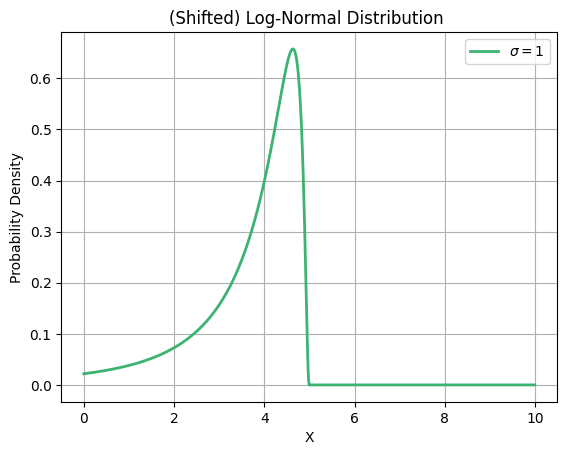

In [7]:
# Parameters for log-normal distribution
mu_0 = 0  # Mean
sigma_0 = 1
shift = 5 # Shift 

x_axis = np.arange(0, 10, 0.01)
shift = shift * np.ones(len(x_axis))

pdf_x_mu0 = reverse_shift_log_normal_pdf(x_axis, shift, mu_0, sigma_0)

# Plot the log-normal probability density function (PDF)
xmin, xmax = plt.xlim()
plt.plot(x_axis, pdf_x_mu0, '-', linewidth=2, color='mediumseagreen', label='$\sigma=1$')
#plt.text(6, 0.42, '$\sigma=1$', color='mediumseagreen')
#plt.plot(x, pdf_x_mu1, '-', linewidth=2, color='slateblue', label='$\sigma=0.25$')
#plt.text(7, 0.15, '$\sigma=0.25$', color='slateblue')

plt.title('(Shifted) Log-Normal Distribution ')
plt.legend(loc='upper right')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

Now, accordingly the probability of a datapoint being distributed according to this log-normal error is: 

$$
p(y_i|y_i < \beta X_i, \beta, \mu, \sigma) = 
\frac{1}{(\beta X_i - y_i)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(\beta X_i - y_i)-\mu)^2}
$$

And hence, the likelihood is: 

$$
L(\delta, \mu, \sigma) = \prod_{i=1}^n s(y_i | y_i < \beta X, \beta X, \mu, \sigma) \\

= \prod_{i=1}^n \frac{1}{(\beta X_i - y_i)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(\beta X_i - y_i)-\mu)^2}
$$

Let $ z_i = \beta X_i -y_i $. Then we have a log likelihood of:

$$
= \sum_{i=1}^n ln(\frac{1}{z_i \sigma \sqrt{2 \pi}} exp(- \frac{(ln z_i - \mu)^2}{2 \sigma^2})) \\ 
= \sum_{i=1}^n ln(\frac{1}{z_i \sigma \sqrt{2 \pi}} ) - \frac{ln^2z_i -2\mu ln z_i + \mu^2}{2 \sigma^2} \\
= \sum_{i=1}^n - ln(z_i \sigma \sqrt{2 \pi}) - \frac{1}{2 \sigma^2}(ln^2z_i -2\mu ln z_i + \mu^2) \\
= \sum_{i=1}^n \frac{1}{2 \sigma^2}(2\mu ln z_i - ln^2 z_i - \mu^2) - ln(z_i \sigma \sqrt{2 \pi}) \\

$$

In [8]:
# Define functions to minimize

def log_rvs_shift_log_normal(z, delta, mu, sigma):
    pdf = []
    z_shift = np.array(delta - z)
    for i in range(len(z_shift)):
        if z_shift[i]>0: 
            part1 = (1/(2 * sigma ** 2)) * (2 * mu * np.log(z_shift[i]) - (np.log(z_shift[i])) ** 2 - mu ** 2) 
            part2 = np.log(z_shift[i] * sigma * np.sqrt(2 *np.pi))
            pdf.append(part1 - part2)
        else:
            pdf.append(-np.inf) # returns -inf at the points where the log normal is undefined 
    return np.array(pdf)

def neg_loglike(params, x, y):
    beta_0 = params[0]
    beta = np.array(params[1:-2])
    mu = params[-2]
    sigma = params[-1]

    y_pred = (np.dot(x, beta)).squeeze() + beta_0
    log_likely = log_rvs_shift_log_normal(y.squeeze(), delta=y_pred.squeeze(), mu=mu, sigma=sigma)
    
    return (-1 * np.sum(log_likely)).squeeze()

In [9]:
trial_params = np.array([0.25, 0.1, 0.004, -0.004, -0.003, 0.0157, -0.0138, 0.108, 0.05, 0.0, 0.25])
print(neg_loglike(trial_params, x, y))

jacobian_ = jacobian(neg_loglike)

print(jacobian_(trial_params, x, y))

1469.9211459456942
[  1773.30207855  44687.96451584 111924.79854488  89006.30452368
 143712.65354546  26419.45936328  10624.35735485   3519.85661138
    273.55854116  -3518.60892996  -9919.36830919]


## Some slightly unexpected behaviour here 

So, something odd happens here, for certain parameter values the negative log likelihood is positive. This is because the log-normal-pdf can be greater than 1, since it's a continous probability distribution it's only bound in that it's integral =1. As a result, for sharply peaked log normals (when both $\mu$ and $\sigma$ are small) we have $x$ values for which $p(x|\mu, \sigma)$ >1, and hence we end up with $- \sum log(p(x|\mu, \sigma))<0$. 

See this example:

In [10]:
params_practise = [8.755e-01,  1.605e-02, -1.870e-03,  5.155e-04, -3.925e-04, 2.349e-02, -2.511e-02,  1.159e-01, 0.05, -2.423e-01,  1.215e-01]
print(f'negative log likelihood: {neg_loglike(params_practise, x, y)}')

delta_shift = np.dot(x, params_practise[1:-2]) + 8.755e-01
print(f'The product of the probabilities: {np.prod(reverse_shift_log_normal_pdf(y, delta_shift, -2.423e-01,  1.215e-01))}')

negative log likelihood: -286.15747161551326
The product of the probabilities: 1.1261572070124742e+147


A few checks with simpler examples that the function returns the values we expect

In [11]:
x_practise1 = np.array([[1, 1.5], [2, 3.5]])
y_practise1 = np.array([0, 0])

params_practise1 = np.array([1, 2, 3, 0, 0.5])
# expect neg_loglike = 28.351402187638193
print(neg_loglike(params_practise1, x_practise1, y_practise1))

28.351402187638193


In [12]:
x_practise2 = np.array([[7, 5], [7, 6]])
y_practise2 = np.array([0, 2])

params_practise2 = np.array([0, 0, 2, 1, 0.5])
# expect neg_loglike = 11.84366
print(f'neg loglikelihood: {neg_loglike(params_practise2, x_practise2, y_practise2)}')

jacobian_ = jacobian(neg_loglike)

print(jacobian_(params_practise2, x_practise2, y_practise2))

neg loglikelihood: 11.843664589238777
[  1.24206807   8.69447652   6.83137441 -10.42068074 -23.14764679]


## Using scipy minimize 

Now we use `scipy.minimize` in order to optimise the function. We are using minimize with the negative of the likelihood which should always be positive.

We can initialise from a random point:

In [13]:
# n_features = 7
# np.random.seed(27)
# params_0 = np.concatenate([np.random.normal(size=n_features+1), [0, 0.25]]) 

Or, we initialise from a point near to where we expect the minimum to be (based on the multiple linear regression coefficients):

In [14]:
params_0 = np.array([0.25, 0.1, 0.004, -0.004, -0.003, 0.0157, -0.0138, 0.108, 0.005, 0.1, 0.25])

There are different methods to optimise, such as Nelder-Mead - which doesn't use the functions derivative.

In [15]:
# Use scipy's minimize function with the Nelder-Mead algorithm
result = minimize(neg_loglike, x0=params_0, args=(x,y), method = 'Nelder-Mead')

result

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: -281.54662629606867
             x: [ 6.611e-01  1.777e-02  1.726e-03  1.491e-03  7.493e-04
                 -8.409e-04  2.862e-03  1.674e-01  7.789e-03 -1.152e-01
                  1.092e-01]
           nit: 1576
          nfev: 2200
 final_simplex: (array([[ 6.611e-01,  1.777e-02, ..., -1.152e-01,
                         1.092e-01],
                       [ 6.682e-01,  1.773e-02, ..., -1.149e-01,
                         1.094e-01],
                       ...,
                       [ 6.622e-01,  1.769e-02, ..., -1.091e-01,
                         1.089e-01],
                       [ 6.665e-01,  1.777e-02, ..., -1.129e-01,
                         1.093e-01]]), array([-2.815e+02, -2.815e+02, -2.815e+02, -2.815e+02,
                       -2.815e+02, -2.815e+02, -2.815e+02, -2.815e+02,
                       -2.815e+02, -2.815e+02, -2.815e+02, -2.815e+02]

Or a method like BFGS which does use the firts derivative:

In [16]:
# derivates of neg_loglike
# jacobian_  = jacobian(neg_loglike)

# result = minimize(neg_loglike, x0=params_0, args=(x,y), method='BFGS', jac = jacobian_, options={'gtol': 1e-6, 'disp':True})
# result

In [17]:
# Extract the MLE from the parameter samples
MLE_params = result.x

MLE_intercept = MLE_params[0]
MLE_beta = MLE_params[1:-2]
MLE_mu = MLE_params[-2]
MLE_sigma = MLE_params[-1]

print("MLE estimates \n--------------\n--------------")
print(f'Intercept:{MLE_intercept}')
print("--------------\nRegression coefficients\n--------------")
for i, var in enumerate(covar):
    print(f'{var}:{MLE_beta[i]}')
print("--------------\nLog normal coefficients\n--------------")
print("Mu:", MLE_mu)
print("Sigma:", MLE_sigma)

MLE estimates 
--------------
--------------
Intercept:0.6611108544514579
--------------
Regression coefficients
--------------
over_65_pc:0.017768562124972433
female_pc:0.0017262627969704858
ALevel_plus_pc:0.0014911662868311005
white_pc:0.0007492791956372528
HYP_afflicted_pc:-0.0008408714507253437
DM_afflicted_pc:0.00286207327194704
STIA_afflicted_pc:0.16739650027984937
GP_LAD_pc:0.007789230075471394
--------------
Log normal coefficients
--------------
Mu: -0.11521423197133887
Sigma: 0.1092382127135566


In [18]:
np.array(MLE_params)
neg_loglike(MLE_params, x, y)

-281.54662629606867

In [19]:
print(f'At the MLE, the negative loglikelihood is: {neg_loglike(MLE_params, x, y)}')

At the MLE, the negative loglikelihood is: -281.54662629606867


And we can plot the shape of the log normal

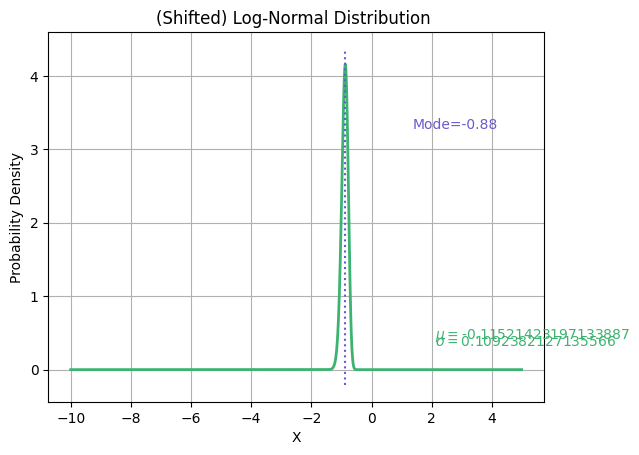

In [20]:
# mode of the log normal 
mode = log_norm_mode(MLE_mu, MLE_sigma)

# plot log normal of MLE parameters 
x_axis = np.arange(-10, 5, 0.01)
pdf_x_mu0 = reverse_shift_log_normal_pdf(x_axis, np.zeros(len(x_axis)), MLE_mu, MLE_sigma)

# Plot the log-normal probability density function (PDF)
xmin, xmax = plt.xlim()
plt.plot(x_axis, pdf_x_mu0, '-', linewidth=2, color='mediumseagreen')
plt.text(2.1, 0.32, f'$\sigma=${MLE_sigma}', color='mediumseagreen')
plt.text(2.1, 0.42, f'$\mu=${MLE_mu}', color='mediumseagreen')
#plt.text(7, 0.15, '$\sigma=0.25$', color='slateblue')

ymin, ymax = plt.ylim()
plt.vlines(-mode, ymin, ymax, color='slateblue', label='Log normal mode', linestyles='dotted')
plt.text(mode+0.5, 3*ymax/4, f'Mode={np.round(-mode,2)}', color='slateblue')

plt.title('(Shifted) Log-Normal Distribution ')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

### Save the results predicted by the model as a .csv 

In [21]:
# The values predicted by the linear regression - conceptually this should be the "true" dementia prevalence rates 
y_pred = np.dot(x, MLE_beta.T) + MLE_intercept
df_dem_plus['log_norm_model_pred'] = y_pred

diagnosis_gap = y_pred.squeeze() - y.squeeze()
df_dem_plus['diagnosis_gap']=diagnosis_gap

df_dem_plus.to_csv(const.output_path+'/log_norm_model/log_norm_model_results.csv')

In [22]:
print(y_pred[:5])

[2.01217597 1.50518022 1.67288187 1.70095567 1.81838323]


And subsquently look at those regions with the largest gap from the regression line - conceptually those with the worst diagnosis rates

In [23]:
most_bad_lads = np.argsort(diagnosis_gap)[-10:]
df_dem_plus.iloc[most_bad_lads, :][['area_name', 'diagnosis_gap']]

,area_name,diagnosis_gap
294,Nuneaton and Bedworth,1.056406
79,Wychavon,1.066434
134,Scarborough,1.068575
60,Worcester,1.083011
75,Redditch,1.090998
288,Plymouth,1.093201
107,Cornwall,1.096865
286,Torridge,1.108802
271,Eden,1.148609
40,South Hams,1.162752


And those regions with the smallest gap - conceptually those with the best diagnosis rates

In [24]:
least_bad_lads = np.argsort(diagnosis_gap)[:10]
df_dem_plus.iloc[least_bad_lads, :][['area_name', 'diagnosis_gap']]

,area_name,diagnosis_gap
77,Rochford,0.521360
123,Surrey Heath,0.636176
63,Eastbourne,0.649599
10,Southend-on-Sea,0.649663
225,Southampton,0.660676
196,East Hampshire,0.668248
29,East Devon,0.672590
99,Tendring,0.689979
3,Lancaster,0.704010
272,Gosport,0.705532


## Evaluate the hessian at the MLE 

We can look at the Hessian evaluated at the MLE.

In [25]:
hessian_ = hessian(neg_loglike)

print(hessian_(MLE_params, x, y))

[[ 3.39987313e+04  8.26471560e+05  2.13709150e+06  1.72312649e+06
   2.66271615e+06  4.95433844e+05  2.01225847e+05  6.52354401e+04
   5.33953732e+03 -2.92573892e+04  7.08270155e+03]
 [ 8.26471560e+05  2.11952946e+07  5.18877592e+07  4.13299635e+07
   6.76925737e+07  1.24655984e+07  4.95519010e+06  1.67009635e+06
   1.28226630e+05 -7.11724840e+05  1.58116371e+05]
 [ 2.13709150e+06  5.18877592e+07  1.34694285e+08  1.08366045e+08
   1.66927619e+08  3.11208951e+07  1.26672131e+07  4.08829048e+06
   3.35380732e+05 -1.84128537e+06  4.28563023e+05]
 [ 1.72312649e+06  4.13299635e+07  1.08366045e+08  8.93044736e+07
   1.32911667e+08  2.47111054e+07  1.00180421e+07  3.24431088e+06
   2.74541078e+05 -1.48574688e+06  3.41103167e+05]
 [ 2.66271615e+06  6.76925737e+07  1.66927619e+08  1.32911667e+08
   2.20352232e+08  3.99917116e+07  1.58635061e+07  5.36029067e+06
   4.13109290e+05 -2.29315380e+06  5.09261654e+05]
 [ 4.95433844e+05  1.24655984e+07  3.11208951e+07  2.47111054e+07
   3.99917116e+07  

In [26]:
def is_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [27]:
np.linalg.eigvals(hessian_(MLE_params, x, y))

array([4.64274465e+08, 8.67086081e+06, 1.04513640e+06, 3.56386189e+05,
       5.28046517e+04, 3.30250261e+04, 5.37236352e+03, 7.94307838e+02,
       2.34942642e+01, 9.88762299e+01, 1.64017444e+02])

In [28]:
is_def(hessian_(MLE_params, x, y))

True

## Alternative model using a half normal distribution instead 

In [29]:
# Negative log likelihood for the half normal distribution 

# Define functions to minimize
def neg_loglike_half_norm(params, x, y):
    beta_0 = params[0]
    beta = np.array(params[1:-1])
    sigma = params[-1]

    log_pdf = []
    y_pred = (np.dot(x, beta)).squeeze() + beta_0
    y = y.reshape(1, len(x)).squeeze()

    z_shift = np.array(y_pred-y)

    for i in range(len(z_shift)):
        if z_shift[i]>0:
            normalising = 1/(sigma* np.sqrt(2*np.pi))
            exp_part = np.exp(-(1/2)*(z_shift[i]/sigma)**2)
            log_pdf.append(np.log(normalising*exp_part))
        else:
            log_pdf.append(-np.inf)

    return np.array(-1 * np.sum(log_pdf))

In [30]:
# Values to initialise from 
params_0 = np.array([1, 0.01, 0.004, -0.004, -0.003, 0.0157, -0.0138, 0.108, 0.01])
sigma_0 = 0.2

In [31]:
neg_loglike_half_norm(np.append(params_0, sigma_0), x, y)

array(1447.51080479)

In [32]:
# Use scipy's minimize function with the Nelder-Mead algorithm
result = minimize(neg_loglike_half_norm, x0=np.append(params_0, sigma_0), args=(x,y), method = 'Nelder-Mead')

result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 88.98883496290142
             x: [ 4.353e-01  2.115e-02  1.911e-03 -5.311e-03 -3.156e-03
                  3.328e-02 -8.461e-03  4.332e-02  6.702e-03  3.178e-01]
           nit: 1151
          nfev: 1819
 final_simplex: (array([[ 4.353e-01,  2.115e-02, ...,  6.702e-03,
                         3.178e-01],
                       [ 4.353e-01,  2.115e-02, ...,  6.702e-03,
                         3.178e-01],
                       ...,
                       [ 4.353e-01,  2.115e-02, ...,  6.702e-03,
                         3.178e-01],
                       [ 4.353e-01,  2.115e-02, ...,  6.702e-03,
                         3.178e-01]]), array([ 8.899e+01,  8.899e+01,  8.899e+01,  8.899e+01,
                        8.899e+01,  8.899e+01,  8.899e+01,  8.899e+01,
                        8.899e+01,  8.899e+01,  8.899e+01]))

In [33]:
# Extract the MLE from the parameter samples
MLE_params = result.x

MLE_intercept = MLE_params[0]
MLE_beta = MLE_params[1:-1]
MLE_sigma = MLE_params[-1]

print("MLE estimates \n--------------\n--------------")
print(f'Intercept:{MLE_intercept}')
print("--------------\nRegression coefficients\n--------------")
for i, var in enumerate(covar):
    print(f'{var}:{MLE_beta[i]}')
print("--------------\nLog normal coefficients\n--------------")
print("Sigma:", MLE_sigma)

MLE estimates 
--------------
--------------
Intercept:0.4352649030048139
--------------
Regression coefficients
--------------
over_65_pc:0.021146183644067475
female_pc:0.0019105602624254147
ALevel_plus_pc:-0.005311153302109716
white_pc:-0.0031561922355858134
HYP_afflicted_pc:0.03328339394120653
DM_afflicted_pc:-0.008461068238775307
STIA_afflicted_pc:0.04331732490389184
GP_LAD_pc:0.0067020452359884235
--------------
Log normal coefficients
--------------
Sigma: 0.3178084248718548


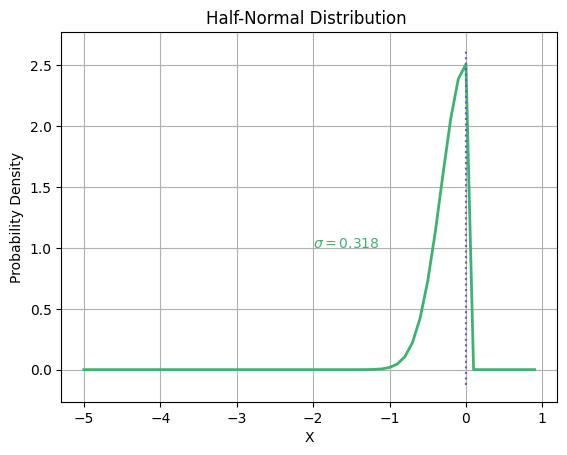

In [34]:
# Plot the half normal distribution from the model 
x_axis = np.arange(-5,1, 0.1)
halfnorm_pdf = stat.halfnorm.pdf(-x_axis, scale=MLE_sigma)
plt.plot(x_axis, halfnorm_pdf, '-', linewidth=2, color='mediumseagreen')
plt.text(-2, 1, f'$\sigma=${np.round(MLE_sigma, 3)}', color='mediumseagreen')
ymin, ymax = plt.ylim()
plt.vlines(0, ymin, ymax, color='slateblue', linestyles='dotted')


plt.title('Half-Normal Distribution ')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

### And again save the results 

In [35]:
# The values predicted by the linear regression - conceptually this should be the "true" dementia prevalence rates 
y_pred = np.dot(x, MLE_beta.T) + MLE_intercept
df_dem_plus['half_norm_model_pred'] = y_pred

diagnosis_gap = y_pred.squeeze() - y.squeeze()
df_dem_plus['half_norm_diagnosis_gap']=diagnosis_gap

df_dem_plus.to_csv(const.output_path+'/half_norm_model/half_norm_model_results.csv')

## Check the model by implementing a linear regression. 

Create a function which we apply `scipy.minimize` to in order ot find the MLE parameters. This code be done using two different objective functions - either:
1. Ordinary least squares (OLS) - based on the assumption that the error is gaussian the MLE parameters of the regression line minimize the OLS function (which is just the sum of the differences squared). 
2. Gaussian error - based on the assumtpion that the error term is gaussian we can minimize the negative log likelihood of the observed data, given a mean of the regression line, and some standard deviation sigma, which is fit as part of the model. 

In [29]:
# The real dementia x and y data 
# Just duplicating this code here to remind myself - but (should be) defined same as above 

# covariates 
covar = ['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc', 'GP_LAD_pc']

# Input data 
x = np.array(df_dem_plus[covar].values.reshape(-1,len(covar)))

# Outcome data 
y = np.array(df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1))

In [30]:
# Define functions to minimize

# OLS
def linear_log_ols(params, x, y):
    beta_0 = params[0]
    beta = np.array(params[1:])

    y_pred = (np.dot(x, beta)).squeeze() + beta_0
    y = y.reshape(1, len(x)).squeeze()
    squares = (y_pred-y)**2
    
    return (np.sum(squares)).squeeze()

# This function uses the built in stat.norm.pdf 
# ... however autograd seems to have a problem differentiating this (despite the fact that it's meant to be compatible)
# negative log likelihood
# def linear_neg_loglike(params, x, y):
#     beta_0 = params[0]
#     beta = np.array(params[1:-1])
#     sigma = params[-1]

#     likely = []
#     y_pred = (np.dot(x, beta)).squeeze() + beta_0
#     y = y.reshape(1, len(x)).squeeze()
#     for i in range(len(y)):
#         likely.append(stat.norm.pdf(y[i], loc=y_pred[i], scale=sigma))
#     #likely = stat.norm.pdf(y, loc=y_pred, scale=sigma)
#     log_likely = np.log(likely)

#     return (-1 * np.sum(log_likely))

# ALTERNATIVE FUNCTION 
# Define functions to minimize
def linear_neg_loglike(params, x, y):
    beta_0 = params[0]
    beta = np.array(params[1:-1])
    sigma = params[-1]

    log_pdf = []
    y_pred = (np.dot(x, beta)).squeeze() + beta_0

    z_shift = np.array(y_pred-y)

    for i in range(len(z_shift)):
        normalising = 1/(sigma* np.sqrt(2*np.pi))
        exp_part = np.exp(-(1/2)*(z_shift[i]/sigma)**2)
        log_pdf.append(np.log(normalising*exp_part))

    return np.array(-1 * np.sum(log_pdf))

In [31]:
# Values to initialise from 
params_0 = np.array([0.1, 0.01, 0.004, -0.004, -0.003, 0.0157, -0.0138, 0.108, 0.01])
sigma_0 = 0.2

# the MLE parameters from the multiple linear regression using sklearn 
regr_coeff = np.load(const.pre_output_path+'/reg_coeff.npy')

In [32]:
# Check the function works by evaluating at a certain point 
linear_neg_loglike(np.append(params_0, sigma_0),x, y)

array(74512.24291338)

In [33]:
# Calculate the gradient at this point 
grad_loglike = grad(linear_neg_loglike)
grad_loglike(np.append(np.array(regr_coeff), 0.1), x, y)

array([-4.54747351e-10,  9.48549355e+06, -1.29128040e+06, -5.76773682e+06,
        2.70987550e+07,  3.84870822e+06,  5.82635404e+05,  8.00881109e+05,
       -8.83095309e+03, -5.81221720e+06])

In [34]:
# Inspect the Hessian at this point 
hessian_ = hessian(linear_neg_loglike)
print(f'Hessian eigenvalues: {np.linalg.eigvals(hessian_(np.append(np.array(regr_coeff), 0.1), x, y))}')
print(f'Hessian matrix positive definite: {is_def(hessian_(np.append(np.array(regr_coeff), 0.1), x, y))}')

Hessian eigenvalues: [1.30919227e+11 2.59471356e+09 3.13191555e+08 1.49108704e+08
 4.98567728e+07 1.03024153e+07 1.49511298e+06 2.32993195e+05
 1.04332132e+04 4.29061267e+04]
Hessian matrix positive definite: True


In [35]:
# Use scipy's minimize function with the Nelder-Mead algorithm
result = minimize(linear_log_ols, x0=params_0, args=(x,y), method = 'Nelder-Mead')

print(result)

# Extract the MLE from the parameter samples
MLE_params = result.x

MLE_intercept = MLE_params[0]
MLE_beta = MLE_params[1:]

print("MLE estimates (OLS model)\n--------------\n--------------")
print(f'Intercept:{MLE_intercept}')
print("--------------\nRegression coefficients\n--------------")
for i, var in enumerate(covar):
    print(f'{var}:{MLE_beta[i]}')

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 2.6187709694255474
             x: [ 1.890e-01  1.489e-02 -7.663e-04 -1.105e-03 -6.946e-04
                  2.260e-02 -3.361e-02  1.259e-01  2.344e-02]
           nit: 1256
          nfev: 1800
 final_simplex: (array([[ 1.890e-01,  1.489e-02, ...,  1.259e-01,
                         2.344e-02],
                       [ 1.825e-01,  1.464e-02, ...,  1.267e-01,
                         2.166e-02],
                       ...,
                       [ 1.800e-01,  1.479e-02, ...,  1.265e-01,
                         2.174e-02],
                       [ 1.819e-01,  1.472e-02, ...,  1.255e-01,
                         2.182e-02]]), array([ 2.619e+00,  2.619e+00,  2.619e+00,  2.619e+00,
                        2.619e+00,  2.619e+00,  2.619e+00,  2.619e+00,
                        2.619e+00,  2.619e+00]))
MLE estimates (OLS model)
--------------
--------------
Inter

In [36]:
params_01 = np.append(regr_coeff, sigma_0)

# Use scipy's minimize function with the Nelder-Mead algorithm
result = minimize(linear_neg_loglike, x0=params_01, args=(x,y), method = 'Nelder-Mead')

result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -18576.76394269803
             x: [ 7.708e-01 -2.874e-04  1.038e-03 -6.738e-04 -2.381e-04
                  1.202e-03 -7.208e-03  8.104e-03  1.890e-02  1.992e-01]
           nit: 1095
          nfev: 1558
 final_simplex: (array([[ 7.708e-01, -2.874e-04, ...,  1.890e-02,
                         1.992e-01],
                       [ 7.708e-01, -2.881e-04, ...,  1.882e-02,
                         1.992e-01],
                       ...,
                       [ 7.708e-01, -2.852e-04, ...,  1.888e-02,
                         1.992e-01],
                       [ 7.709e-01, -2.888e-04, ...,  1.888e-02,
                         1.992e-01]]), array([-1.858e+04, -1.858e+04, -1.858e+04, -1.858e+04,
                       -1.858e+04, -1.858e+04, -1.858e+04, -1.858e+04,
                       -1.858e+04, -1.858e+04, -1.858e+04]))

In [37]:
# Extract the MLE from the parameter samples
MLE_params = result.x

MLE_intercept = MLE_params[0]
MLE_beta = MLE_params[1:-1]
MLE_sigma = MLE_params[-1]

print("MLE estimates (Gaussian model)\n--------------\n--------------")
print(f'Intercept:{MLE_intercept}')
print("--------------\nRegression coefficients\n--------------")
for i, var in enumerate(covar):
    print(f'{var}:{MLE_beta[i]}')
print("--------------\nGaussian standard deviation\n--------------")
print("Sigma:", MLE_sigma)

MLE estimates (Gaussian model)
--------------
--------------
Intercept:0.7707829886914952
--------------
Regression coefficients
--------------
over_65_pc:-0.0002873618308516717
female_pc:0.0010380125608645827
ALevel_plus_pc:-0.0006738113775407944
white_pc:-0.0002380678370793179
HYP_afflicted_pc:0.0012022646415519042
DM_afflicted_pc:-0.0072079795781840265
STIA_afflicted_pc:0.008103690541657806
GP_LAD_pc:0.01890396011042375
--------------
Gaussian standard deviation
--------------
Sigma: 0.1991983297913804


In [38]:
# Calculate the gradient at this point 
grad_loglike = grad(linear_neg_loglike)
grad_loglike(np.array(MLE_params), x, y)

array([-1.17251454e+01, -7.84929848e+02,  1.46881033e+04, -1.93374209e+04,
       -8.51846707e+03,  7.96294751e+02, -3.15947870e+02, -2.43879031e+01,
        1.50019642e+02,  4.21916375e+01])

In [39]:
# Inspect the Hessian at this point 
hessian_ = hessian(linear_neg_loglike)
print(f'Hessian eigenvalues: {np.linalg.eigvals(hessian_(np.array(MLE_params), x, y))}')
print(f'Hessian matrix positive definite: {is_def(hessian_(np.array(MLE_params), x, y))}')

Hessian eigenvalues: [3.29935317e+10 6.30872369e+08 7.87262874e+07 2.48700487e+07
 4.81189843e+06 2.59609302e+06 3.79794460e+05 5.98379747e+04
 2.69535307e+03 1.08188520e+04]
Hessian matrix positive definite: True
